In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from PyIF import te_compute as te
from sklearn import metrics

from osgeo import gdal, osr, ogr
from tqdm import tqdm
from scipy import stats, spatial, signal, fftpack
from scipy.optimize import curve_fit


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
gdf = gp.read_file("../shape/sierra_catchments.shp")

In [3]:

def get_fnf(stn_id):
    '''
    Query CA DWR website to get reservoir storage for an area of interest
    '''
    print("**** Fetching FNF for {} ****".format(stn_id))

    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=8&dur_code=D&Start=2000-09-01&End=2021-09-01".format(stn_id)
    df = pd.read_csv(url)

    df[stid] = pd.to_numeric(df['VALUE'], errors='coerce').interpolate(how = 'linear') * 0.0283168 * 86400 # cfs --> cms 
    df.index = pd.to_datetime(df['DATE TIME'])
    df.index.names = ['date']
    df.drop(['STATION_ID', "VALUE", "DURATION", "SENSOR_NUMBER", 
             "SENSOR_TYPE", "OBS DATE",'DATE TIME', "DATA_FLAG", "UNITS"], axis = 1, inplace = True)

    df[df[stid] < 0] = np.nan
#     df[stid] = df[stid].rolling(7).mean()
    return df  #.interpolate(how = 'linear')# .interpolate(how = 'polynomial', order = 3)

In [4]:
results_df = []

**** Fetching FNF for SHA ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.06277908249597967,  b=1.7208094853587106, K = 2.3873291352462576


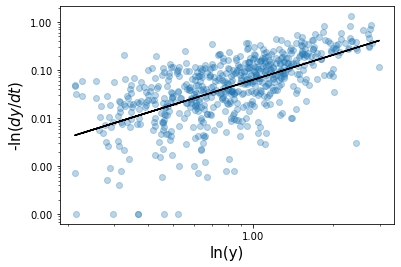

**** Fetching FNF for YRS ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07903782008074613,  b=0.9884796016973044, K = 85.80255436706706


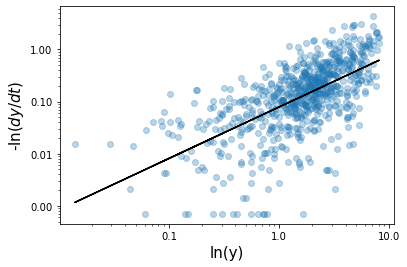

**** Fetching FNF for NHG ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.11611676158836534,  b=0.7255475295680301, K = 2.6436181406057915


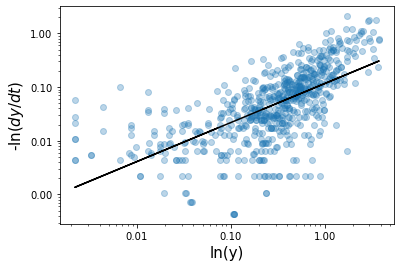

**** Fetching FNF for EXC ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.09246732533329079,  b=1.0254103565920532, K = 40.35403253304759


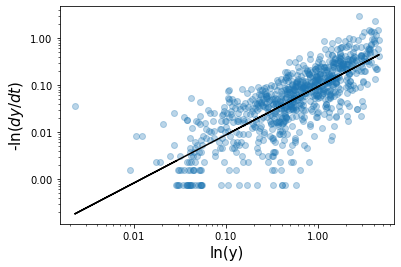

**** Fetching FNF for PNF ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.06662937048068754,  b=0.9352782431829156, K = 14.450754880251237


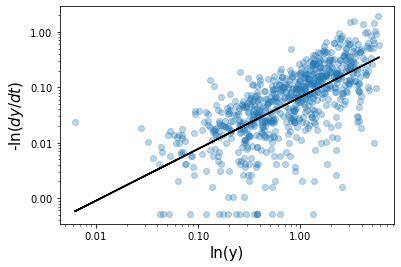

**** Fetching FNF for SCC ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.043696388123092136,  b=0.6292051714919912, K = 1.6969092422992111


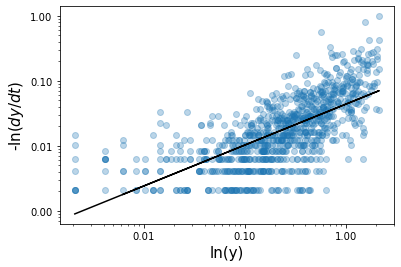

**** Fetching FNF for MKM ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1303701686096028,  b=0.6234543330745023, K = 1.6557203756054832


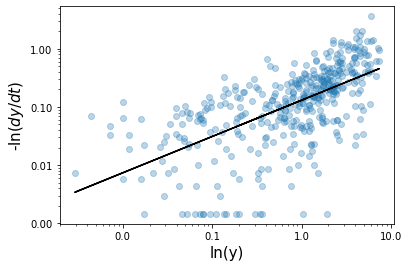

**** Fetching FNF for TRM ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.061592277986458714,  b=0.9849763986283628, K = 65.56193646670401


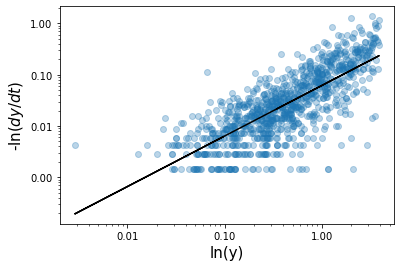

**** Fetching FNF for ORO ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.0782133283831071,  b=1.0705841405182015, K = 15.167488513119041


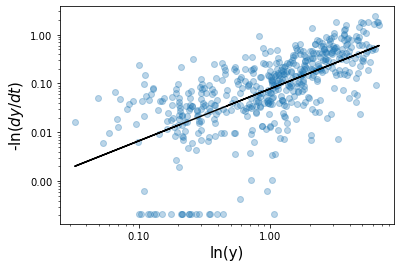

**** Fetching FNF for NML ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.08549979078879649,  b=0.8133713167958171, K = 4.358233165616565


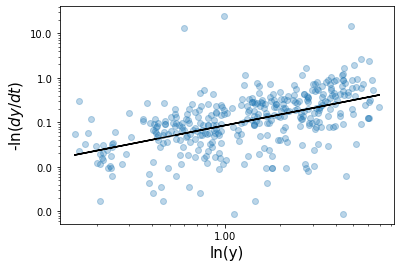

**** Fetching FNF for MHB ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.058896589301483206,  b=1.0075699398348554, K = 133.10144622227338


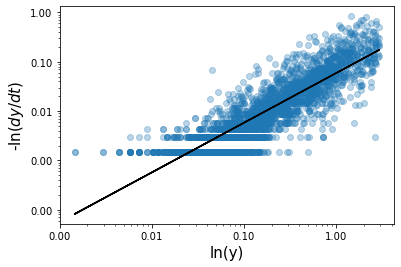

**** Fetching FNF for NAT ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.10733381695153621,  b=0.8521909059936902, K = 5.765483590321655


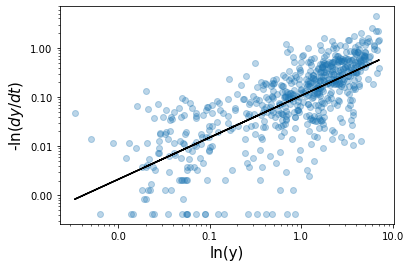

**** Fetching FNF for ISB ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.060347041196199956,  b=1.0918216540695695, K = 11.890677260533126


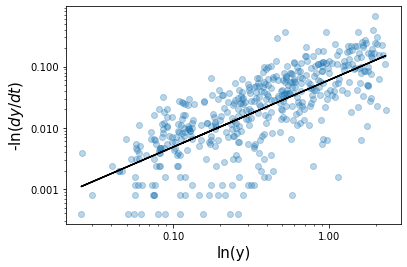

**** Fetching FNF for TLG ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.10149378148510024,  b=0.8535283012593645, K = 5.827257474297123


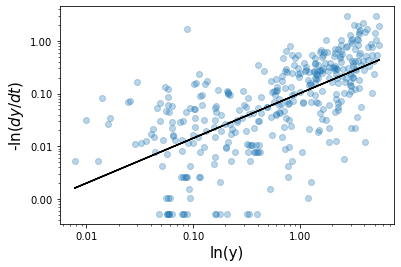

**** Fetching FNF for SJF ****


<ipython-input-5-e228299697ba>:41: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.08652146298192483,  b=0.9667270081752327, K = 29.054405845633454


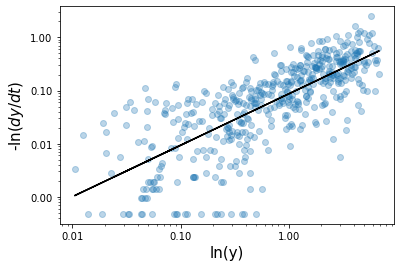

In [5]:
for stid in list(gdf['stid'])[::-1]:
    
    akm2 = float(gdf[gdf['stid'] == stid].area_km2)
        
    fnf_df = get_fnf(stid)

    hdf = fnf_df.copy()

    hdf.columns = ['y']
    hdf['y'] = hdf['y'] / float(akm2) * 1e-9 * 1e6 #
    hdf['dy'] = hdf['y'].diff()

    hdf = hdf.dropna()

    # Drop rows with increasing baseflow 
    droprows = []
    for idx, row in hdf.reset_index().iterrows():
        if row['dy'] > 0:
            droprows.append([idx + x for x in list(range(-1,3))])

    drs = [item for sublist in droprows for item in sublist]
    drs = [x for x in drs if x>=0 and x <len(hdf)]

    odf = hdf.reset_index().drop(hdf.reset_index().index[drs]).set_index(['date'])

    # Remove vvv small values 
    odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]

    # Remove outliers 
    odf = odf[(np.abs(stats.zscore(odf['y'])) < 3)]

    # keep only summer 
    odf['midx'] = odf.index.month
    odf[odf['midx'].isin([6,7,8,9,10])]

    odf.dropna(inplace = True)
    x = odf['y'].values
    y = odf['dy'].abs().values

    def f(x, a, b):
        return np.log(a*x**b)

    popt,pcov=curve_fit(f, x, np.log(y))

    ax = plt.gca()

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(x,y, alpha = 0.3)

    a, b = popt
    print("Parameters: a={},  b={}, K = {}".format(a,b, abs(b/(1-b))))

    #parameter form curve_fit
    py=a*x**b

    ax.loglog(x,py,  color="k")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
    # ax.set_xlim([0.01,10])
    # ax.set_ylim([0.0001,1])
    ax.set_ylabel("-ln($dy/dt$)", size = 15)
    ax.set_xlabel("ln(y)", size = 15)
    plt.show()

In [6]:
# Set up outlists 
results_df = []
param_df = []

# Loop through catchments 
for stid in list(gdf['stid'])[:]:
        
    akm2 = float(gdf[gdf['stid'] == stid].area_km2)
        
    fnf_df = get_fnf(stid)

    hdf = fnf_df.copy()

    hdf.columns = ['y']
    hdf['y'] = hdf['y'] / float(akm2) * 1e-9 * 1e6 #
    hdf['dy'] = hdf['y'].diff()

    hdf = hdf.dropna()

    # Drop rows with increasing baseflow 
    droprows = []
    for idx, row in hdf.reset_index().iterrows():
        if row['dy'] > 0:
            droprows.append([idx + x for x in list(range(-1,3))])

    drs = [item for sublist in droprows for item in sublist]
    drs = [x for x in drs if x>=0 and x <len(hdf)]

    odf = hdf.reset_index().drop(hdf.reset_index().index[drs]).set_index(['date'])

    # Remove vvv small values 
    odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]

    # Remove outliers 
    odf = odf[(np.abs(stats.zscore(odf['y'])) < 3)]

    # keep only summer 
    odf['midx'] = odf.index.month
    odf[odf['midx'].isin([6,7,8,9,])]

    odf.dropna(inplace = True)
    x = odf['y'].values
    y = odf['dy'].abs().values

    def f(x, a, b):
        return np.log(a*x**b)

    popt,pcov=curve_fit(f, x, np.log(y))
#     ax = plt.gca()

#     ax.set_xscale("log")
#     ax.set_yscale("log")

#     ax.scatter(x,y, alpha = 0.3)
    
    temp_df = pd.DataFrame([x,y]).T
    temp_df.columns = ['y','dy']
    temp_df['id'] = [stid for x in range(len(temp_df))]
    results_df.append(temp_df)
    
    pdf = pd.DataFrame([popt[0],popt[1],stid]).T
    pdf.columns = ['a','b','id']
    param_df.append(pdf)

    a, b = popt
    print("Parameters: a={},  b={}, K = {}".format(a,b, abs(b/(1-b))))

    #parameter form curve_fit
    py=a*x**b

#     ax.loglog(x,py,  color="k")
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     # ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
#     # ax.set_xlim([0.01,10])
#     # ax.set_ylim([0.0001,1])
#     ax.set_ylabel("-ln($dy/dt$)", size = 15)
#     ax.set_xlabel("ln(y)", size = 15)
#     plt.show()

**** Fetching FNF for SJF ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.08652146298192483,  b=0.9667270081752327, K = 29.054405845633454
**** Fetching FNF for TLG ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.10149378148510024,  b=0.8535283012593645, K = 5.827257474297123
**** Fetching FNF for ISB ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.060347041196199956,  b=1.0918216540695695, K = 11.890677260533126
**** Fetching FNF for NAT ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.10733381695153621,  b=0.8521909059936902, K = 5.765483590321655
**** Fetching FNF for MHB ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.058896589301483206,  b=1.0075699398348554, K = 133.10144622227338
**** Fetching FNF for NML ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.08549979078879649,  b=0.8133713167958171, K = 4.358233165616565
**** Fetching FNF for ORO ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.0782133283831071,  b=1.0705841405182015, K = 15.167488513119041
**** Fetching FNF for TRM ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.061592277986458714,  b=0.9849763986283628, K = 65.56193646670401
**** Fetching FNF for MKM ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1303701686096028,  b=0.6234543330745023, K = 1.6557203756054832
**** Fetching FNF for SCC ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.043696388123092136,  b=0.6292051714919912, K = 1.6969092422992111
**** Fetching FNF for PNF ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.06662937048068754,  b=0.9352782431829156, K = 14.450754880251237
**** Fetching FNF for EXC ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.09246732533329079,  b=1.0254103565920532, K = 40.35403253304759
**** Fetching FNF for NHG ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.11611676158836534,  b=0.7255475295680301, K = 2.6436181406057915
**** Fetching FNF for YRS ****


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07903782008074613,  b=0.9884796016973044, K = 85.80255436706706
**** Fetching FNF for SHA ****
Parameters: a=0.06277908249597967,  b=1.7208094853587106, K = 2.3873291352462576


<ipython-input-6-7c4d4daca1fb>:46: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


In [7]:
# Master plot
plot_df = pd.concat(results_df, axis = 0)
popt_global,pcov_global=curve_fit(f, plot_df['y'], np.log(plot_df['dy']))
py_glob = popt_global[0]*plot_df['y']**popt_global[1]

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


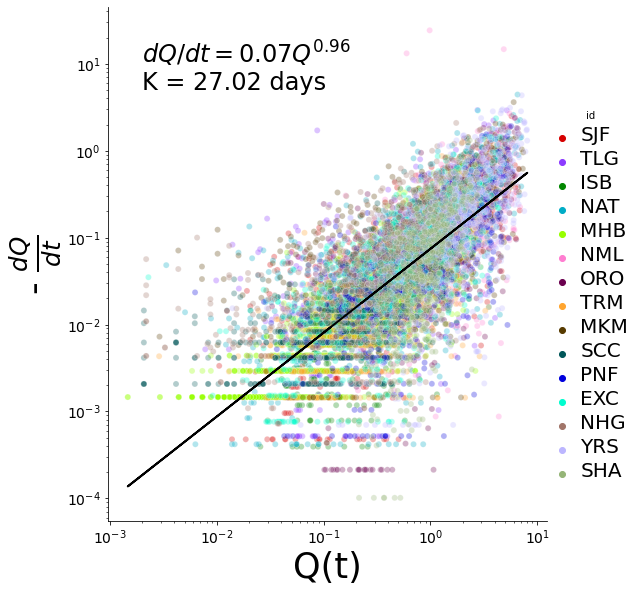

In [12]:
palette = sns.color_palette(cc.glasbey, n_colors=15)

t = sns.relplot(data=plot_df, x='y', y='dy', hue='id', palette = palette, aspect=1, alpha = 0.3, ax = ax)
plt.plot(plot_df['y'],py_glob, color = 'black', linewidth = 2)
text = ("$dQ/dt = {{{}}} Q^{{{}}}$").format(round(popt_global[0],2), round(popt_global[1],2))
text2 = ("K = {} days").format(round(popt_global[1]/(1-popt_global[1]),2))

# plt.annotate(text, xy = (2e-8,3e-4), size = 12)
# plt.annotate(text2, xy = (2e-8,1e-4), size = 12)
plt.annotate(text, xy = (2e-3,1e1), size = 24)
plt.annotate(text2, xy = (2e-3,5e0), size = 24)
# plt.ylim([1e-1,1e3])
# plt.xlim([1e-1,1e3])
plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'- $\frac{dQ}{dt}$', size = 35)
plt.xlabel("Q(t)", size = 30)

# plt.legend(fontsize='large', title_fontsize='0')
t.fig.set_size_inches(8,8)
plt.setp(t._legend.get_texts(), fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()